In [338]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import nltk
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import gzip
import seaborn as sns
import string, re
from time import time
import warnings

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sambo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sambo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sambo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [339]:
pages = []
RAN = 42
for i in range(1,500):
    url = 'https://www.amazon.com/adidas-Womens-Cloudfoam-Pure-Running/product-reviews/B09JSXQ3YX/ref=cm_cr_arp_d_paging_btm_next_501?ie=UTF8&reviewerType=all_reviews&pageNumber={}'.format(i)
    pages.append(url)

In [340]:
import requests

cookies = {
    'ad-id': 'A0EIkkLeJEigg9ioDp9cqd4',
    'ad-privacy': '0',
}

headers = {
    'Connection': 'keep-alive',
    'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="96", "Google Chrome";v="96"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.45 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Dest': 'iframe',
    'Referer': 'https://s.amazon-adsystem.com/iu3?d=amazon.com&slot=navFooter&a1=01019858643e3c5ffd851d342918ec6d3372a82612b185a97c81ceac3d75db7e3f04&a2=0101ab8d517a331cb50a17cae980927ff0dc40169cd17755efdf08e1d631d7b78a31&old_oo=0&ts=1637701310671&s=Ae8g3pCHs5ythEza23r973kYxKDJw7jW490u6aa2EOzv&gdpr_consent=&gdpr_consent_avl=&cb=1637701310671',
    'Accept-Language': 'en-US,en;q=0.9',
}
params = (
    ('exlist', 'n-zeotap-4_n-rb-HMT3_adelphic_n-lucid'),
    ('fv', '1.0'),
    ('a', 'cm'),
    ('ep', 'NLmAUJwOczdiLfS7QPdybuNke30UqfwcM3I2JYg1q_ycRcfszt5Jm83PE2b7TWxJ'),
)

response = requests.get('https://s.amazon-adsystem.com/v3/pr', headers=headers, params=params, cookies=cookies)

In [341]:
resp = requests.get(pages[0], headers=headers)

In [342]:
soup = BeautifulSoup(resp.text, "html.parser") # html.parser, lxml

In [343]:
reviews = soup.find_all("div", {"class": "a-section review aok-relative"})

In [344]:
def get_review_stars(soup_obj: BeautifulSoup) -> str:
    try:
        review_str = soup_obj.find('a', {"class": "a-link-normal"}).get_text()
        return review_str
    except Exception as e:
        return 'no_stars'
        print(e)

In [345]:
def get_review_body(soup_obj: BeautifulSoup) -> str:
    try:
        review_body = soup_obj.find('span', 
            {"class": "a-size-base review-text review-text-content"}
        ).get_text().strip()
        return review_body
    except Exception as e:
        return 'no_body'
        print(e)

In [346]:
def get_review_date(soup_obj: BeautifulSoup) -> str:
    try:
        review_date = soup_obj.find('span', 
            {"class": "a-size-base a-color-secondary review-date"}
        ).get_text().strip()
        return review_date
    except Exception as e:
        return 'no_date'
        print(e)
def get_review_components(soup_obj: BeautifulSoup) -> dict:
    return {
        'stars': get_review_stars(soup_obj) , 
        'body': get_review_body(soup_obj), 
        'date': get_review_date(soup_obj)
    }

In [347]:
records = [get_review_components(rev) for rev in reviews]
df = pd.DataFrame.from_records(records)
#df.to_csv('amazon_reviews2.csv')

In [348]:
ALL_REVIEWS = []

for u in pages:
    #print(u)
    resp = requests.get(u, headers=headers)
    soup = BeautifulSoup(resp.text, "html.parser")
    reviews = soup.find_all("div", {"class": "a-section review aok-relative"})
    records = [get_review_components(rev) for rev in reviews]
    ALL_REVIEWS.extend(records) 

In [423]:
df = pd.DataFrame.from_records(ALL_REVIEWS)
print(df.shape)

(4990, 3)


In [424]:
df['stars'].replace({'0.0 out of 5 stars': 0,'1.0 out of 5 stars': 1,'2.0 out of 5 stars': 2,'3.0 out of 5 stars': 3,
                    '4.0 out of 5 stars': 4,'5.0 out of 5 stars': 5}, inplace=True)

In [425]:
a=[ 'VINE VOICE','TOP 1000 REVIEWER','TOP 500 REVIEWER']
df = df[~df.stars.isin(a)]

5    3503
4     540
3     385
1     328
2     226
Name: stars, dtype: int64


<AxesSubplot:ylabel='stars'>

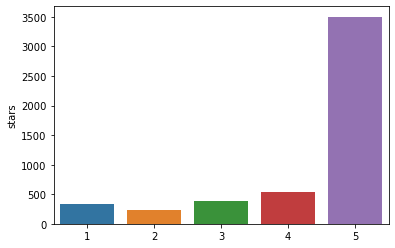

In [426]:
x = df['stars'].value_counts()
print(x)
sns.barplot(x.index,x)

Null counts:  stars     0
body      0
date      0
target    0
dtype: int64
1    4043
0     939
Name: target, dtype: int64


<AxesSubplot:ylabel='target'>

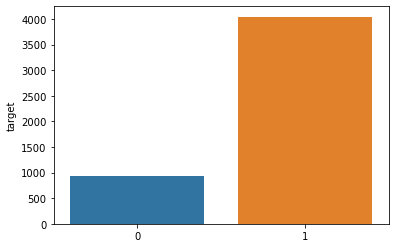

In [427]:
df['target'] = np.where((df['stars'] > 3), 1, 0)
print('Null counts: ', df.isna().sum())
x = df['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [428]:
df = df.dropna(subset=['body'])
df = df.drop('date', 1)

In [430]:
duplicate = df[df.duplicated()]

In [431]:
# convert to lower
# delete punctuations
#corpus = df.body.str.lower()
#corpus = corpus.str.replace('[^\w\s]',' ')
#df['body'] = corpus

In [432]:
df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))
print(df.word_count.describe())
print('Positive reviews: ', df[df['target']==1]['word_count'].mean())
print('Negative reviews: ', df[df['target']==0]['word_count'].mean())

count    4982.000000
mean       31.847049
std        32.738055
min         0.000000
25%        11.000000
50%        24.000000
75%        42.000000
max       545.000000
Name: word_count, dtype: float64
Positive reviews:  28.91714073707643
Negative reviews:  44.46219382321619


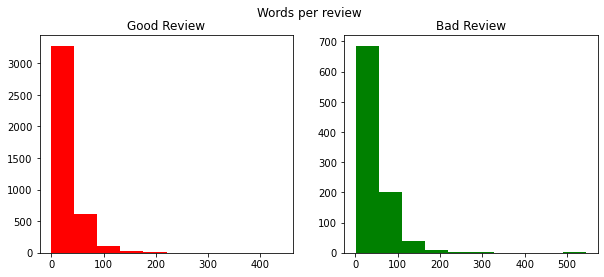

In [433]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df[df['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Good Review')
train_words=df[df['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Bad Review')
fig.suptitle('Words per review')
plt.show()

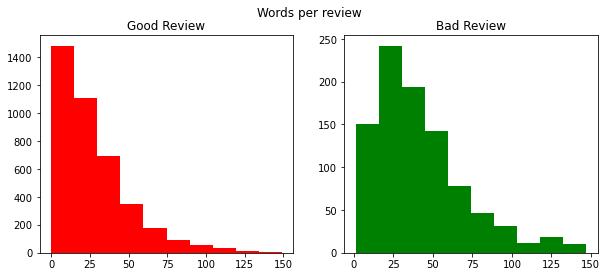

In [434]:
df = df[df['word_count'] <= 150]

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df[df['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Good Review')
train_words=df[df['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Bad Review')
fig.suptitle('Words per review')
plt.show()

In [435]:
print('Positive reviews: ', df[df['target']==1]['word_count'].mean())
print('Negative reviews: ', df[df['target']==0]['word_count'].mean())

Positive reviews:  27.336574420344053
Negative reviews:  41.35249457700651


In [436]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

## PREPROCESSING

In [437]:
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text= re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

In [438]:
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

In [439]:
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(a)
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

In [440]:
df['clean_text'] = df['body'].apply(lambda x: finalpreprocess(x))
df['clean_text'].describe()

count            4933
unique           4730
top       comfortable
freq               45
Name: clean_text, dtype: object

## Model Split and Testing

In [441]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix

In [442]:
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"],df["target"],test_size=0.2)

X_train_tok = [nltk.word_tokenize(i) for i in X_train]  
X_test_tok = [nltk.word_tokenize(i) for i in X_test]
print(len(X_train), len(y_train), len(X_test), len(y_test))

3946 3946 987 987


In [443]:
vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors = vectorizer.fit_transform(X_train) 
X_test_vectors = vectorizer.transform(X_test)
print(X_train_vectors.shape, X_test_vectors.shape)

(3946, 3460) (987, 3460)


Logistic Regression: 
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       174
           1       0.93      0.97      0.95       813

    accuracy                           0.91       987
   macro avg       0.86      0.80      0.83       987
weighted avg       0.90      0.91      0.90       987

AUC: 0.9316954376440316


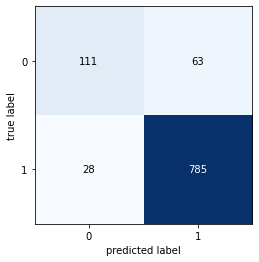

In [476]:
lr=LogisticRegression(solver = 'sag', C=10, penalty = 'l2', random_state=RAN)
lr.fit(X_train_vectors, y_train)  
#Predict y value for test dataset
y_predict = lr.predict(X_test_vectors)
y_prob = lr.predict_proba(X_test_vectors)[:,1]
print('Logistic Regression: ')
print(classification_report(y_test,y_predict))
cf_LR = confusion_matrix(y_test, y_predict)
plot_confusion_matrix(conf_mat=cf_LR);
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

Naive Bayes:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       174
           1       0.93      0.92      0.93       813

    accuracy                           0.88       987
   macro avg       0.80      0.80      0.80       987
weighted avg       0.88      0.88      0.88       987

AUC: 0.9212261950205709


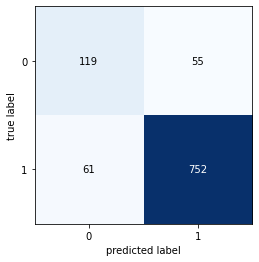

In [475]:
nb = MultinomialNB(alpha = 0.5, fit_prior = False)
nb.fit(X_train_vectors, y_train)
#Predict y value for test dataset
y_predict = nb.predict(X_test_vectors)
y_prob = nb.predict_proba(X_test_vectors)[:,1]
print('Naive Bayes:')
print(classification_report(y_test,y_predict))
cf_NB = confusion_matrix(y_test, y_predict)
plot_confusion_matrix(conf_mat=cf_NB);
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)